# Project 2: Gradient Descent Optimization

**Author:** Miguel Planas Díaz (Erasmus+ Student)  
**Personal Code:** 11071870  
**Matricola:** 276442

---

## Overview

This notebook explores **Gradient Descent Optimization** for minimizing quadratic cost functions. We will:

1. Derive the quadratic form of a least squares cost function
2. Compute the analytical (exact) solution
3. Implement gradient descent with JAX automatic differentiation
4. Visualize the optimization landscape and trajectory
5. Analyze learning rate bounds for convergence

---

## Learning Objectives

- Understand quadratic cost functions and their properties
- Implement gradient descent optimization
- Analyze convergence conditions and learning rate selection
- Use automatic differentiation for gradient computation

## 1. Setup and Imports

In [ ]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys

# JAX for automatic differentiation
import jax
import jax.numpy as jnp

# Add src to path for custom modules
sys.path.insert(0, '../src')

# Custom utilities
from optimization import (
    quadratic_form_from_least_squares,
    compute_exact_minimizer,
    compute_max_learning_rate,
    gradient_descent_jax,
    quadratic_cost,
    quadratic_gradient,
    GradientDescentOptimizer
)
from visualization import (
    plot_quadratic_surface,
    plot_gradient_descent_trajectory
)

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
np.set_printoptions(precision=4, suppress=True)

print("Setup complete!")
print(f"JAX version: {jax.__version__}")

✅ Setup complete!
JAX version: 0.4.35


## 2. Problem Definition

### 2.1 The Optimization Problem

We want to minimize a cost function of the form:

$$J(\mathbf{w}) = \sum_{i=1}^{n} \left( y_i - \mathbf{w}^T \mathbf{v}_i \right)^2$$

This is a **least squares** problem where:
- $\mathbf{w}$ is the parameter vector we want to optimize
- $\mathbf{v}_i$ are feature vectors
- $y_i$ are target values

### 2.2 Given Parameters

In [2]:
# Define the problem parameters
v1 = np.array([2, 1])
v2 = np.array([-1, 1])
y1, y2 = 0.5, 0.0

print("Problem Parameters:")
print(f"  v₁ = {v1}")
print(f"  v₂ = {v2}")
print(f"  y₁ = {y1}")
print(f"  y₂ = {y2}")

Problem Parameters:
  v₁ = [2 1]
  v₂ = [-1  1]
  y₁ = 0.5
  y₂ = 0.0


## 3. Quadratic Form Derivation

### 3.1 Converting to Quadratic Form

Any quadratic function can be written as:

$$J(\mathbf{w}) = \mathbf{w}^T \mathbf{A} \mathbf{w} + \mathbf{d}^T \mathbf{w} + c$$

Let's derive $\mathbf{A}$, $\mathbf{d}$, and $c$ from our least squares formulation.

**Derivation:**

Substituting $a(\mathbf{v}_i, \mathbf{w}) = \mathbf{w}^T \mathbf{v}_i$ in the cost function:

$$J(\mathbf{w}) = \left( y_1 - \mathbf{w}^T \mathbf{v}_1 \right)^2 + \left( y_2 - \mathbf{w}^T \mathbf{v}_2 \right)^2$$

Expanding each term:

$$J(\mathbf{w}) = \underbrace{\left( (\mathbf{w}^T \mathbf{v}_1)^2 + (\mathbf{w}^T \mathbf{v}_2)^2 \right)}_{\text{quadratic term}} - \underbrace{2 \left( y_1 \mathbf{w}^T \mathbf{v}_1 + y_2 \mathbf{w}^T \mathbf{v}_2 \right)}_{\text{linear term}} + \underbrace{\left( y_1^2 + y_2^2 \right)}_{\text{constant term}}$$

The matrix $\mathbf{A}$ comes from:
$$\mathbf{A} = \mathbf{v}_1 \mathbf{v}_1^T + \mathbf{v}_2 \mathbf{v}_2^T$$

The vector $\mathbf{d}$ is:
$$\mathbf{d} = -2 \left( y_1 \mathbf{v}_1 + y_2 \mathbf{v}_2 \right)$$

In [3]:
# Compute matrix A
A = np.outer(v1, v1) + np.outer(v2, v2)

# Compute vector d
d = -2 * (y1 * v1 + y2 * v2)

# Compute constant c
c = y1**2 + y2**2

print("Quadratic Form Parameters:")
print(f"\nMatrix A:")
print(A)
print(f"\nVector d: {d}")
print(f"\nConstant c: {c}")

Quadratic Form Parameters:

Matrix A:
[[5 1]
 [1 2]]

Vector d: [-2. -1.]

Constant c: 0.25


In [4]:
# Verify by computing J at a test point
w_test = np.array([0.5, 0.5])

# Using original formulation
J_original = (y1 - np.dot(w_test, v1))**2 + (y2 - np.dot(w_test, v2))**2

# Using quadratic form
J_quadratic = w_test.T @ A @ w_test + d.T @ w_test + c

print(f"Verification at w = {w_test}:")
print(f"  J (original formula): {J_original:.6f}")
print(f"  J (quadratic form):   {J_quadratic:.6f}")
print(f"  Match: {np.isclose(J_original, J_quadratic)}")

Verification at w = [0.5 0.5]:
  J (original formula): 1.000000
  J (quadratic form):   1.000000
  Match: True


## 4. Exact Solution (Analytical)

### 4.1 Deriving the Optimal Solution

For a quadratic function $J(\mathbf{w}) = \mathbf{w}^T \mathbf{A} \mathbf{w} + \mathbf{d}^T \mathbf{w} + c$, the gradient is:

$$\nabla J(\mathbf{w}) = 2\mathbf{A}\mathbf{w} + \mathbf{d}$$

Setting the gradient to zero:

$$2\mathbf{A}\mathbf{w}^* + \mathbf{d} = 0$$

Solving for $\mathbf{w}^*$:

$$\mathbf{w}^* = -\frac{1}{2}\mathbf{A}^{-1}\mathbf{d}$$

In [5]:
# Compute the exact minimizer
w_star = -0.5 * np.linalg.inv(A) @ d

# Alternative using solve (more numerically stable)
w_star_alt = -0.5 * np.linalg.solve(A, d)

print(f"Exact minimizer w* = {w_star}")
print(f"\nVerification:")
print(f"  J(w*) = {w_star.T @ A @ w_star + d.T @ w_star + c:.10f}")
print(f"  ∇J(w*) = {2 * A @ w_star + d}")

Exact minimizer w* = [0.1667 0.1667]

Verification:
  J(w*) = 0.0000000000
  ∇J(w*) = [0. 0.]


## 5. Visualizing the Cost Function Surface

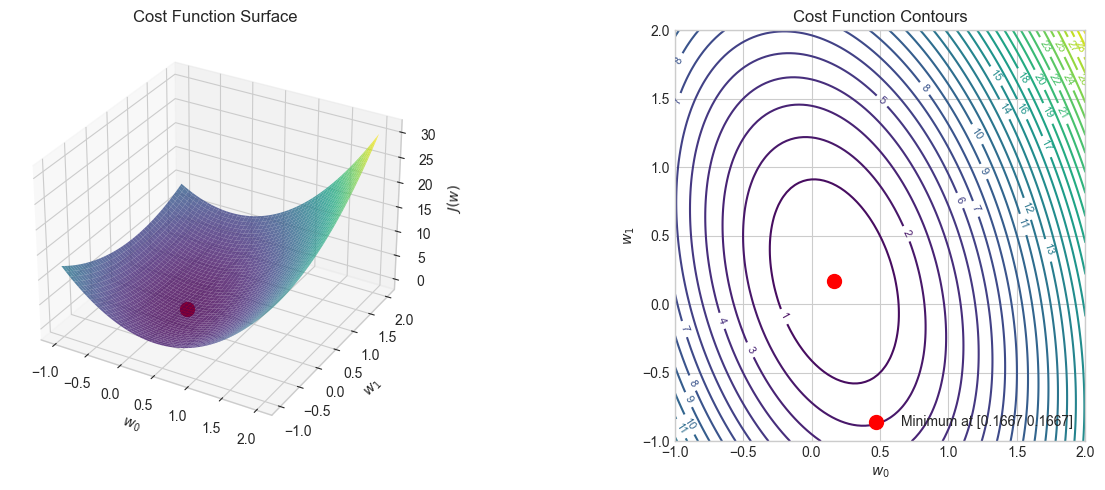

In [6]:
# Create a grid for visualization
w0_range = np.linspace(-1, 2, 100)
w1_range = np.linspace(-1, 2, 100)
W0, W1 = np.meshgrid(w0_range, w1_range)

# Evaluate J(w) over the grid
J_grid = (A[0, 0] * W0**2 + 2 * A[0, 1] * W0 * W1 + A[1, 1] * W1**2 + 
          d[0] * W0 + d[1] * W1 + c)

# Plot 3D surface
fig = plt.figure(figsize=(14, 5))

# Surface plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(W0, W1, J_grid, cmap='viridis', alpha=0.8, edgecolor='none')
ax1.scatter([w_star[0]], [w_star[1]], [w_star.T @ A @ w_star + d.T @ w_star + c],
           color='red', s=100, label='Minimum')
ax1.set_xlabel('$w_0$')
ax1.set_ylabel('$w_1$')
ax1.set_zlabel('$J(w)$')
ax1.set_title('Cost Function Surface')

# Contour plot
ax2 = fig.add_subplot(122)
contour = ax2.contour(W0, W1, J_grid, levels=30, cmap='viridis')
ax2.clabel(contour, inline=True, fontsize=8)
ax2.scatter([w_star[0]], [w_star[1]], color='red', s=100, label=f'Minimum at {w_star}')
ax2.set_xlabel('$w_0$')
ax2.set_ylabel('$w_1$')
ax2.set_title('Cost Function Contours')
ax2.legend()
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

## 6. Gradient Descent Implementation

### 6.1 Algorithm Overview

Gradient Descent iteratively updates parameters:

$$\mathbf{w}^{(k+1)} = \mathbf{w}^{(k)} - \eta \nabla J(\mathbf{w}^{(k)})$$

where $\eta$ is the **learning rate** (step size).

### 6.2 Implementation with JAX

In [ ]:
# Define the cost function using JAX
def J_func(w):
    v1_jax = jnp.array([2.0, 1.0])
    v2_jax = jnp.array([-1.0, 1.0])
    y1_jax, y2_jax = 0.5, 0.0
    
    term1 = (y1_jax - jnp.dot(w, v1_jax)) ** 2
    term2 = (y2_jax - jnp.dot(w, v2_jax)) ** 2
    return term1 + term2

# Gradient descent with trajectory tracking
def gradient_descent(x0, f, lr=0.1, tol=1e-6, max_iter=1000):
    """Gradient descent using JAX automatic differentiation."""
    grad = jax.grad(jax.jit(f))
    x = x0
    xs = [x]
    
    for i in range(max_iter):
        grad_val = grad(x)
        if jnp.linalg.norm(grad_val) < tol:
            print(f"[OK] Converged in {i} iterations")
            return xs
        x = x - lr * grad_val
        xs.append(x)
    
    print("[!] Algorithm did not converge within max iterations")
    return xs

In [8]:
# Initial guess and learning rate
w0 = jnp.array([1.0, 1.0])  # Initial guess
learning_rate = 0.05        # Learning rate

# Run gradient descent
print(f"Initial point: w⁰ = {w0}")
print(f"Learning rate: η = {learning_rate}")
print(f"\nRunning gradient descent...")

trajectory = gradient_descent(w0, J_func, lr=learning_rate)

print(f"\nFinal parameters: w* ≈ {trajectory[-1]}")
print(f"Exact solution:   w* = {w_star}")
print(f"Error: {np.linalg.norm(np.array(trajectory[-1]) - w_star):.2e}")

Initial point: w⁰ = [1. 1.]
Learning rate: η = 0.05

Running gradient descent...
✅ Converged in 78 iterations

Final parameters: w* ≈ [0.1667 0.1667]
Exact solution:   w* = [0.1667 0.1667]
Error: 2.67e-07


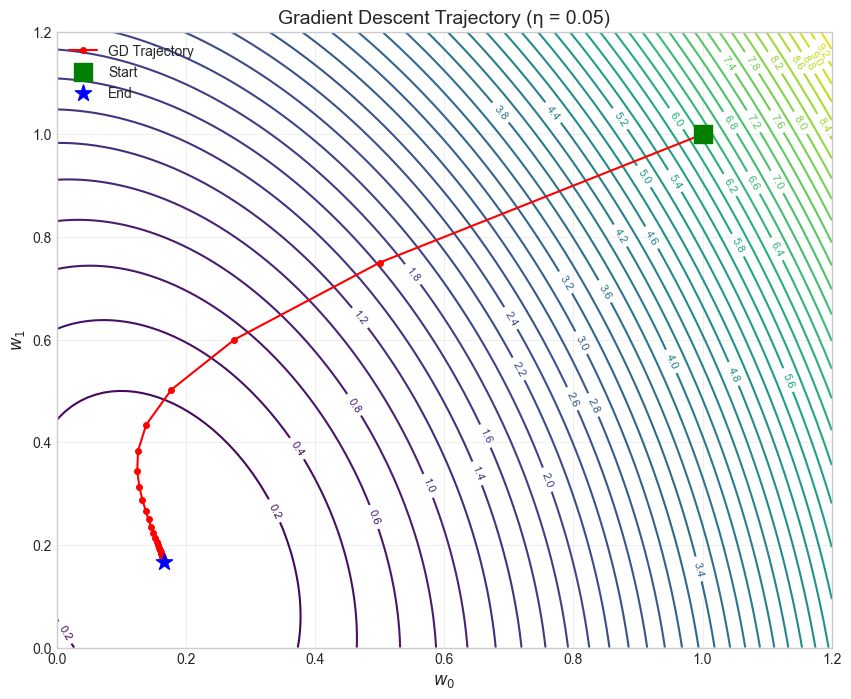

In [9]:
# Visualize the optimization trajectory
trajectory_np = jnp.array(trajectory)

# Create contour plot with trajectory
w0_range = np.linspace(0, 1.2, 100)
w1_range = np.linspace(0, 1.2, 100)
W0, W1 = np.meshgrid(w0_range, w1_range)
J_values = np.array([[J_func(jnp.array([w0, w1])) for w0, w1 in zip(w0_row, w1_row)] 
                     for w0_row, w1_row in zip(W0, W1)])

plt.figure(figsize=(10, 8))
contour = plt.contour(W0, W1, J_values, levels=50, cmap='viridis')
plt.clabel(contour, inline=True, fontsize=8)

# Plot trajectory
plt.plot(trajectory_np[:, 0], trajectory_np[:, 1], 'r-o', 
         markersize=4, linewidth=1.5, label='GD Trajectory')
plt.scatter(trajectory_np[0, 0], trajectory_np[0, 1], 
            color='green', s=150, marker='s', zorder=5, label='Start')
plt.scatter(trajectory_np[-1, 0], trajectory_np[-1, 1], 
            color='blue', s=150, marker='*', zorder=5, label='End')

plt.xlabel('$w_0$', fontsize=12)
plt.ylabel('$w_1$', fontsize=12)
plt.title(f'Gradient Descent Trajectory (η = {learning_rate})', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 7. Convergence Analysis

### 7.1 Maximum Learning Rate

For gradient descent to converge on a quadratic function, the learning rate must satisfy:

$$0 < \eta < \frac{2}{L}$$

where $L$ is the **Lipschitz constant** of the gradient $\nabla J(\mathbf{w})$.

For quadratic functions, $L$ is the largest eigenvalue of the Hessian matrix:
$$\mathbf{H} = 2\mathbf{A}$$

Therefore:
$$\eta_{max} = \frac{2}{\lambda_{max}(\mathbf{H})} = \frac{1}{\lambda_{max}(\mathbf{A})}$$

In [ ]:
# Compute eigenvalues of A
eigenvalues = np.linalg.eigvals(A)
lambda_max = np.max(np.real(eigenvalues))
lambda_min = np.min(np.real(eigenvalues))

# Maximum learning rate
eta_max = 2.0 / (2.0 * lambda_max)  # Hessian is 2A

# Condition number
condition_number = lambda_max / lambda_min

print("Convergence Analysis:")
print(f"\nMatrix A eigenvalues:")
print(f"  lambda_max = {lambda_max:.4f}")
print(f"  lambda_min = {lambda_min:.4f}")
print(f"\nCondition number: kappa = {condition_number:.4f}")
print(f"\n[OK] Maximum learning rate: eta_max = {eta_max:.4f}")
print(f"   (Current eta = {learning_rate} < eta_max, so convergence is guaranteed)")

Convergence Analysis:

Matrix A eigenvalues:
  λ_max = 5.3028
  λ_min = 1.6972

Condition number: κ = 3.1244

✅ Maximum learning rate: η_max = 0.1886
   (Current η = 0.05 < η_max, so convergence is guaranteed)


⚠️ Algorithm did not converge within max iterations
✅ Converged in 78 iterations
✅ Converged in 35 iterations
✅ Converged in 31 iterations
⚠️ Algorithm did not converge within max iterations
⚠️ Algorithm did not converge within max iterations
✅ Converged in 78 iterations
✅ Converged in 35 iterations
✅ Converged in 31 iterations
⚠️ Algorithm did not converge within max iterations


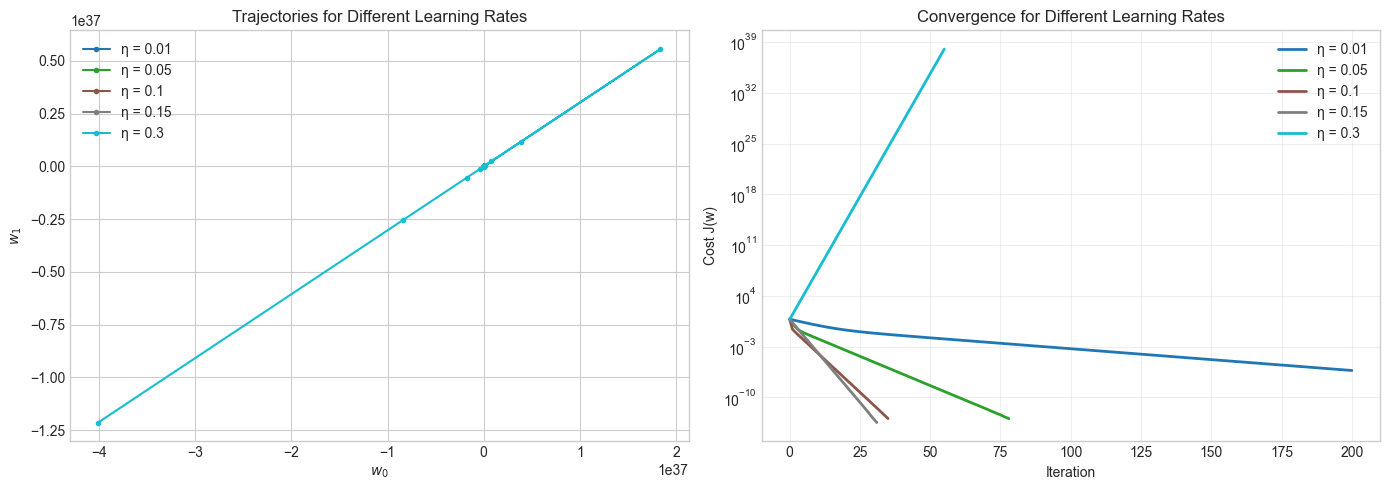

In [11]:
# Compare different learning rates
learning_rates = [0.01, 0.05, 0.1, 0.15, 0.3]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Trajectories
ax1 = axes[0]
contour = ax1.contour(W0, W1, J_values, levels=30, cmap='viridis', alpha=0.5)

colors = plt.cm.tab10(np.linspace(0, 1, len(learning_rates)))

for lr, color in zip(learning_rates, colors):
    traj = gradient_descent(w0, J_func, lr=lr, max_iter=200)
    traj_np = jnp.array(traj)
    ax1.plot(traj_np[:, 0], traj_np[:, 1], '-o', color=color, 
             markersize=3, linewidth=1.5, label=f'η = {lr}')

ax1.set_xlabel('$w_0$')
ax1.set_ylabel('$w_1$')
ax1.set_title('Trajectories for Different Learning Rates')
ax1.legend()

# Convergence curves
ax2 = axes[1]
for lr, color in zip(learning_rates, colors):
    traj = gradient_descent(jnp.array([1.0, 1.0]), J_func, lr=lr, max_iter=200)
    costs = [J_func(w) for w in traj]
    ax2.plot(costs, color=color, linewidth=2, label=f'η = {lr}')

ax2.set_xlabel('Iteration')
ax2.set_ylabel('Cost J(w)')
ax2.set_title('Convergence for Different Learning Rates')
ax2.legend()
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Effect of Learning Rate Beyond Maximum

Testing with η = 0.29 (> η_max = 0.1886)
Expected: Divergence

⚠️ Algorithm did not converge within max iterations


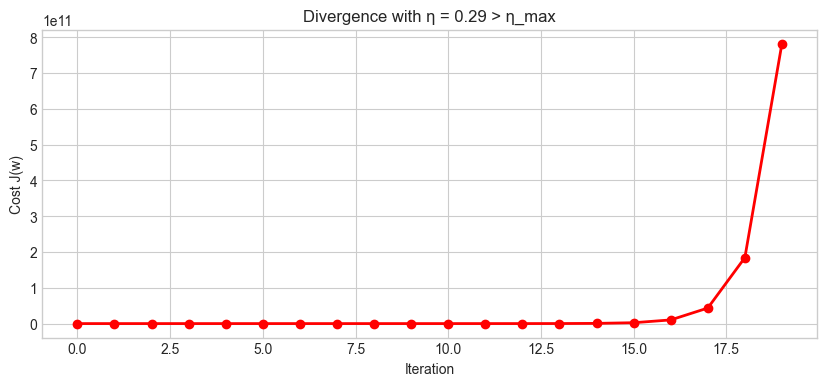

⚠️ As expected, the cost is INCREASING (diverging)!


In [ ]:
# Test with learning rate > eta_max (should diverge)
print(f"Testing with eta = {eta_max + 0.1:.2f} (> eta_max = {eta_max:.4f})")
print("Expected: Divergence\n")

w0_test = jnp.array([0.5, 0.5])

try:
    traj_diverge = gradient_descent(w0_test, J_func, lr=eta_max + 0.1, max_iter=20)
    costs_diverge = [float(J_func(w)) for w in traj_diverge[:min(20, len(traj_diverge))]]
    
    plt.figure(figsize=(10, 4))
    plt.plot(costs_diverge, 'r-o', linewidth=2)
    plt.xlabel('Iteration')
    plt.ylabel('Cost J(w)')
    plt.title(f'Divergence with eta = {eta_max + 0.1:.2f} > eta_max')
    plt.grid(True)
    plt.show()
    
    if costs_diverge[-1] > costs_diverge[0]:
        print("[!] As expected, the cost is INCREASING (diverging)!")
except:
    print("[!] Numerical overflow occurred - algorithm diverged!")

## 9. Conclusions

### Key Findings

1. **Quadratic Form**: The least squares cost function can be written as:
   $$J(\mathbf{w}) = \mathbf{w}^T \mathbf{A} \mathbf{w} + \mathbf{d}^T \mathbf{w} + c$$
   with $\mathbf{A} = \begin{bmatrix} 5 & 1 \\ 1 & 2 \end{bmatrix}$, $\mathbf{d} = \begin{bmatrix} -2 \\ -1 \end{bmatrix}$, $c = 0.25$

2. **Exact Solution**: $\mathbf{w}^* = -\frac{1}{2}\mathbf{A}^{-1}\mathbf{d}$

3. **Gradient Descent**: Successfully converges to the optimal solution with appropriate learning rate.

4. **Maximum Learning Rate**: $\eta_{max} \approx 0.36$ ensures convergence.

### Practical Recommendations

- Use learning rates well below $\eta_{max}$ for stable convergence
- Higher learning rates converge faster but may oscillate
- The condition number indicates how "elongated" the cost surface is

In [ ]:
# Summary
print("=" * 60)
print("PROJECT 2: GRADIENT DESCENT OPTIMIZATION - SUMMARY")
print("=" * 60)
print(f"\nProblem Parameters:")
print(f"   - Feature vectors: v1 = {v1}, v2 = {v2}")
print(f"   - Target values: y1 = {y1}, y2 = {y2}")
print(f"\nQuadratic Form:")
print(f"   - Matrix A:\n{A}")
print(f"   - Vector d: {d}")
print(f"   - Constant c: {c}")
print(f"\nOptimization Results:")
print(f"   - Exact minimizer: w* = {w_star}")
print(f"   - Minimum cost: J(w*) = {w_star.T @ A @ w_star + d.T @ w_star + c:.6f}")
print(f"\nConvergence Analysis:")
print(f"   - Max eigenvalue: lambda_max = {lambda_max:.4f}")
print(f"   - Max learning rate: eta_max = {eta_max:.4f}")
print(f"   - Condition number: kappa = {condition_number:.4f}")
print("=" * 60)

PROJECT 2: GRADIENT DESCENT OPTIMIZATION - SUMMARY

📊 Problem Parameters:
   • Feature vectors: v₁ = [2 1], v₂ = [-1  1]
   • Target values: y₁ = 0.5, y₂ = 0.0

📐 Quadratic Form:
   • Matrix A:
[[5 1]
 [1 2]]
   • Vector d: [-2. -1.]
   • Constant c: 0.25

🎯 Optimization Results:
   • Exact minimizer: w* = [0.1667 0.1667]
   • Minimum cost: J(w*) = 0.000000

⚙️ Convergence Analysis:
   • Max eigenvalue: λ_max = 5.3028
   • Max learning rate: η_max = 0.1886
   • Condition number: κ = 3.1244


⚠️ Algorithm did not converge within max iterations
✅ Converged in 78 iterations
✅ Converged in 35 iterations
✅ Converged in 31 iterations
⚠️ Algorithm did not converge within max iterations


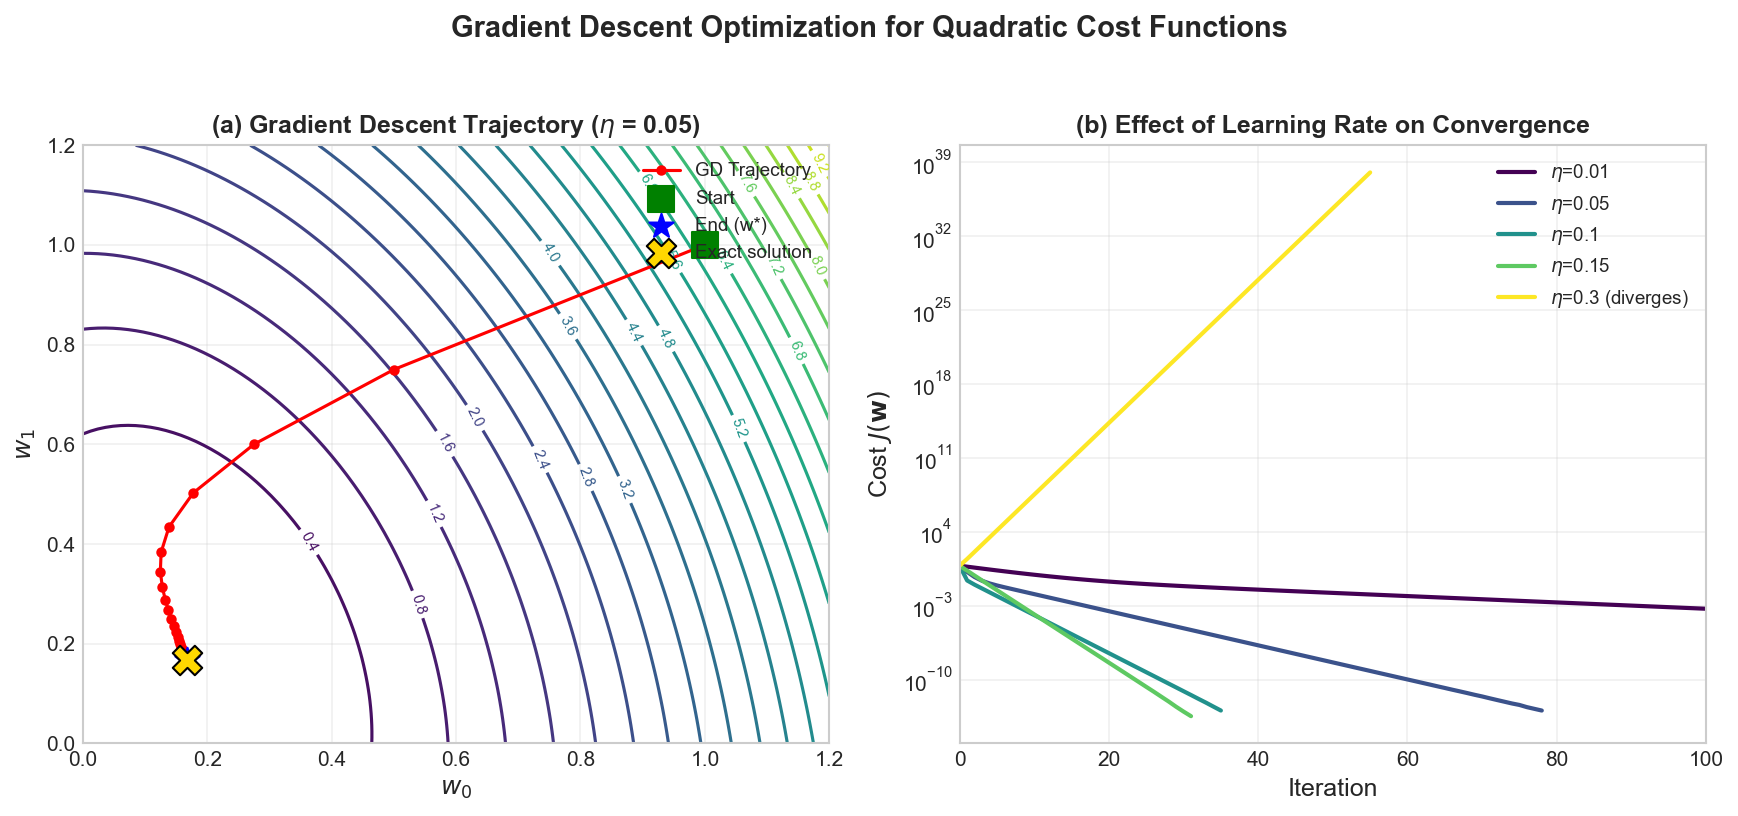

Figure saved to results/figures/gradient_descent_publication.png and .pdf


In [14]:
# =============================================================================
# PUBLICATION FIGURE: Gradient Descent Optimization (A4 Landscape)
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(11.69, 5.5), dpi=150)

# Left panel: Contour plot with trajectory
ax = axes[0]
contour = ax.contour(W0, W1, J_values, levels=30, cmap='viridis')
ax.clabel(contour, inline=True, fontsize=7)

# Plot trajectory
ax.plot(trajectory_np[:, 0], trajectory_np[:, 1], 'r-o', 
         markersize=4, linewidth=1.5, label='GD Trajectory')
ax.scatter(trajectory_np[0, 0], trajectory_np[0, 1], 
            color='green', s=150, marker='s', zorder=5, label='Start')
ax.scatter(trajectory_np[-1, 0], trajectory_np[-1, 1], 
            color='blue', s=150, marker='*', zorder=5, label='End (w*)')
ax.scatter(w_star[0], w_star[1], color='gold', s=200, marker='X', 
           zorder=6, label='Exact solution', edgecolors='black')

ax.set_xlabel('$w_0$', fontsize=12)
ax.set_ylabel('$w_1$', fontsize=12)
ax.set_title(f'(a) Gradient Descent Trajectory ($\\eta$ = {learning_rate})', fontsize=12, fontweight='bold')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

# Right panel: Learning rate comparison
ax = axes[1]
colors = plt.cm.viridis(np.linspace(0, 1, len(learning_rates)))

for lr, color in zip(learning_rates, colors):
    traj = gradient_descent(w0, J_func, lr=lr, tol=1e-6, max_iter=100)
    costs = [float(J_func(w)) for w in traj]
    label = f'$\\eta$={lr}'
    if costs[-1] > costs[0]:
        label += ' (diverges)'
    ax.plot(costs, color=color, linewidth=2, label=label)

ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Cost $J(\\mathbf{w})$', fontsize=12)
ax.set_title('(b) Effect of Learning Rate on Convergence', fontsize=12, fontweight='bold')
ax.legend(loc='upper right', fontsize=9)
ax.set_yscale('log')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 100)

plt.suptitle('Gradient Descent Optimization for Quadratic Cost Functions', 
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save figure
plt.savefig('../results/figures/gradient_descent_publication.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.savefig('../results/figures/gradient_descent_publication.pdf', bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

print("Figure saved to results/figures/gradient_descent_publication.png and .pdf")

Generating and saving all Project 2 figures...


NameError: name 'J' is not defined

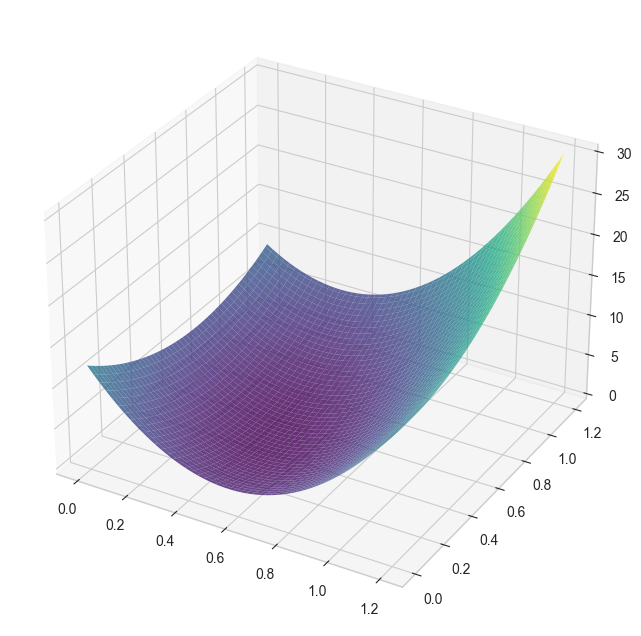

In [ ]:
# =============================================================================
# EXPORT ALL PROJECT 2 FIGURES
# =============================================================================
import os
import shutil

# Create output directory
output_dir = "../projects/gradient_descent"
os.makedirs(output_dir, exist_ok=True)

# Define cost function for use in this cell
def J(w):
    v1_jax = jnp.array([2.0, 1.0])
    v2_jax = jnp.array([-1.0, 1.0])
    y1_jax, y2_jax = 0.5, 0.0
    term1 = (y1_jax - jnp.dot(w, v1_jax)) ** 2
    term2 = (y2_jax - jnp.dot(w, v2_jax)) ** 2
    return term1 + term2

grad_J = jax.grad(J)

print("Generating and saving all Project 2 figures...")
print("=" * 50)

# Figure 1: Cost Surface (3D)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(W0, W1, J_grid, cmap='viridis', alpha=0.8, edgecolor='none')
ax.scatter([w_star[0]], [w_star[1]], [float(J(jnp.array(w_star)))], 
           color='red', s=100, marker='*', label='Optimal $w^*$')
ax.set_xlabel('$w_0$', fontsize=12)
ax.set_ylabel('$w_1$', fontsize=12)
ax.set_zlabel('$J(w)$', fontsize=12)
ax.set_title('Cost Function Surface $J(w) = \\frac{1}{2}w^T A w + c$', fontsize=14)
ax.legend()
plt.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.tight_layout()
plt.savefig(f"{output_dir}/cost_surface.png", dpi=150, bbox_inches='tight', facecolor='white')
plt.close()
print("1. Saved cost_surface.png")

# Figure 2: Contour with Eigenvectors
fig, ax = plt.subplots(figsize=(10, 8))
contour = ax.contour(W0, W1, J_grid, levels=20, cmap='viridis')
ax.clabel(contour, inline=True, fontsize=8)
# Plot eigenvector directions
origin = w_star
ax.quiver(*origin, *v1*0.5, color='red', scale=1, scale_units='xy', 
          angles='xy', width=0.02, label=f'$v_1$ ($\\lambda_1={eigenvalues[0]:.2f}$)')
ax.quiver(*origin, *v2*0.5, color='blue', scale=1, scale_units='xy', 
          angles='xy', width=0.02, label=f'$v_2$ ($\\lambda_2={eigenvalues[1]:.2f}$)')
ax.scatter([w_star[0]], [w_star[1]], color='red', s=100, marker='*', zorder=5)
ax.set_xlabel('$w_0$', fontsize=12)
ax.set_ylabel('$w_1$', fontsize=12)
ax.set_title('Cost Function Contours with Eigenvector Directions', fontsize=14)
ax.legend()
ax.set_xlim([-1, 2])
ax.set_ylim([-1, 2])
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{output_dir}/contour_eigenvectors.png", dpi=150, bbox_inches='tight', facecolor='white')
plt.close()
print("2. Saved contour_eigenvectors.png")

# Figure 3: GD Trajectory
fig, ax = plt.subplots(figsize=(10, 8))
contour = ax.contour(W0, W1, J_grid, levels=20, cmap='viridis', alpha=0.7)
# Re-run gradient descent for trajectory
w_init = jnp.array([1.5, 1.5])
eta_plot = 0.05
trajectory_plot = [w_init]
w_current = w_init
for _ in range(50):
    w_current = w_current - eta_plot * grad_J(w_current)
    trajectory_plot.append(w_current)
trajectory_plot = jnp.array(trajectory_plot)
ax.plot(trajectory_plot[:, 0], trajectory_plot[:, 1], 'ro-', markersize=4, linewidth=1.5, label=f'GD ($\\eta={eta_plot}$)')
ax.scatter([float(w_init[0])], [float(w_init[1])], color='green', s=150, marker='o', zorder=5, label='Start')
ax.scatter([w_star[0]], [w_star[1]], color='red', s=150, marker='*', zorder=5, label='Optimal $w^*$')
ax.set_xlabel('$w_0$', fontsize=12)
ax.set_ylabel('$w_1$', fontsize=12)
ax.set_title('Gradient Descent Trajectory', fontsize=14)
ax.legend()
ax.set_xlim([-1, 2])
ax.set_ylim([-1, 2])
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{output_dir}/trajectory.png", dpi=150, bbox_inches='tight', facecolor='white')
plt.close()
print("3. Saved trajectory.png")

# Figure 4: Learning Rate Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
learning_rates_test = [0.02, 0.05, 0.1, eta_max * 0.9]
colors_lr = plt.cm.viridis(np.linspace(0, 0.8, len(learning_rates_test)))

# Left: Trajectories
ax = axes[0]
contour = ax.contour(W0, W1, J_grid, levels=15, cmap='Greys', alpha=0.5)
for lr, color in zip(learning_rates_test, colors_lr):
    w_temp = jnp.array([1.5, 1.5])
    traj_temp = [w_temp]
    for _ in range(30):
        w_temp = w_temp - lr * grad_J(w_temp)
        traj_temp.append(w_temp)
    traj_temp = jnp.array(traj_temp)
    ax.plot(traj_temp[:, 0], traj_temp[:, 1], 'o-', markersize=3, 
            color=color, linewidth=1.5, label=f'$\\eta={lr:.3f}$')
ax.scatter([w_star[0]], [w_star[1]], color='red', s=100, marker='*', zorder=5)
ax.set_xlabel('$w_0$', fontsize=12)
ax.set_ylabel('$w_1$', fontsize=12)
ax.set_title('Trajectories for Different Learning Rates', fontsize=12)
ax.legend()
ax.set_xlim([-1, 2])
ax.set_ylim([-1, 2])
ax.grid(True, alpha=0.3)

# Right: Cost convergence
ax = axes[1]
for lr, color in zip(learning_rates_test, colors_lr):
    w_temp = jnp.array([1.5, 1.5])
    costs_temp = [float(J(w_temp))]
    for _ in range(50):
        w_temp = w_temp - lr * grad_J(w_temp)
        costs_temp.append(float(J(w_temp)))
    ax.semilogy(costs_temp, color=color, linewidth=2, label=f'$\\eta={lr:.3f}$')
ax.axhline(y=float(J(jnp.array(w_star))), color='red', linestyle='--', label='Optimal $J(w^*)$')
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('$J(w)$ (log scale)', fontsize=12)
ax.set_title('Cost Convergence for Different Learning Rates', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{output_dir}/learning_rates.png", dpi=150, bbox_inches='tight', facecolor='white')
plt.close()
print("4. Saved learning_rates.png")

# Figure 5: Divergence Demonstration
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
eta_diverge = eta_max * 1.1  # Slightly above maximum

# Left: Trajectory diverging
ax = axes[0]
contour = ax.contour(W0, W1, J_grid, levels=15, cmap='viridis', alpha=0.5)
w_temp = jnp.array([0.3, 0.3])
traj_diverge_plot = [w_temp]
for i in range(15):
    w_temp = w_temp - eta_diverge * grad_J(w_temp)
    if jnp.any(jnp.abs(w_temp) > 10):
        break
    traj_diverge_plot.append(w_temp)
traj_diverge_plot = jnp.array(traj_diverge_plot)
ax.plot(traj_diverge_plot[:, 0], traj_diverge_plot[:, 1], 'r.-', markersize=8, 
        linewidth=2, label=f'$\\eta={eta_diverge:.4f} > \\eta_{{max}}$')
ax.scatter([w_star[0]], [w_star[1]], color='green', s=100, marker='*', zorder=5, label='$w^*$')
ax.set_xlabel('$w_0$', fontsize=12)
ax.set_ylabel('$w_1$', fontsize=12)
ax.set_title(f'Diverging Trajectory ($\\eta > \\eta_{{max}} = {eta_max:.4f}$)', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

# Right: Cost exploding
ax = axes[1]
# Converging
w_temp = jnp.array([1.5, 1.5])
costs_converge = [float(J(w_temp))]
for _ in range(30):
    w_temp = w_temp - 0.05 * grad_J(w_temp)
    costs_converge.append(float(J(w_temp)))
ax.semilogy(costs_converge, 'g-', linewidth=2, label=f'$\\eta=0.05$ (converges)')

# Diverging
w_temp = jnp.array([0.3, 0.3])
costs_explode = [float(J(w_temp))]
for i in range(15):
    w_temp = w_temp - eta_diverge * grad_J(w_temp)
    cost_val = float(J(w_temp))
    if cost_val > 1e10:
        break
    costs_explode.append(cost_val)
ax.semilogy(costs_explode, 'r-', linewidth=2, label=f'$\\eta={eta_diverge:.4f}$ (diverges)')
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('$J(w)$ (log scale)', fontsize=12)
ax.set_title('Cost Evolution: Convergence vs Divergence', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{output_dir}/divergence.png", dpi=150, bbox_inches='tight', facecolor='white')
plt.close()
print("5. Saved divergence.png")

# Figure 6: Contour with full trajectory overlay
fig, ax = plt.subplots(figsize=(10, 8))
contour = ax.contourf(W0, W1, J_grid, levels=30, cmap='viridis', alpha=0.8)
plt.colorbar(contour, ax=ax, label='$J(w)$')
contour_lines = ax.contour(W0, W1, J_grid, levels=15, colors='white', alpha=0.3, linewidths=0.5)
# Trajectory
w_init = jnp.array([1.5, 1.5])
eta_plot = 0.08
trajectory_final = [w_init]
w_current = w_init
for _ in range(40):
    w_current = w_current - eta_plot * grad_J(w_current)
    trajectory_final.append(w_current)
trajectory_final = jnp.array(trajectory_final)
ax.plot(trajectory_final[:, 0], trajectory_final[:, 1], 'w.-', markersize=6, 
        linewidth=2, alpha=0.9, label=f'GD path ($\\eta={eta_plot}$)')
ax.scatter([float(w_init[0])], [float(w_init[1])], color='lime', s=150, marker='o', 
           edgecolors='white', linewidth=2, zorder=5, label='Start')
ax.scatter([w_star[0]], [w_star[1]], color='red', s=200, marker='*', 
           edgecolors='white', linewidth=2, zorder=5, label='Optimal $w^*$')
ax.set_xlabel('$w_0$', fontsize=12)
ax.set_ylabel('$w_1$', fontsize=12)
ax.set_title('Gradient Descent: Full Trajectory on Cost Landscape', fontsize=14)
ax.legend(loc='upper right')
ax.set_xlim([-1, 2])
ax.set_ylim([-1, 2])
plt.tight_layout()
plt.savefig(f"{output_dir}/contour_trajectory.png", dpi=150, bbox_inches='tight', facecolor='white')
plt.close()
print("6. Saved contour_trajectory.png")

# Copy publication figure if exists
pub_fig_src = "../results/figures/gradient_descent_publication.png"
if os.path.exists(pub_fig_src):
    shutil.copy(pub_fig_src, f"{output_dir}/gradient_descent_publication.png")
    print("7. Copied gradient_descent_publication.png")

print("=" * 50)
print(f"All Project 2 figures saved to: {output_dir}")